In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [5]:
# Defining Cairo Params and RL Params

kappa = 6.9
chi = 2.6 * 2 * jnp.pi
kerr = 0.002
time_coeff = 10.0
snr_coeff = 10.
smoothness_coeff = 10.0
ideal_sep = 2.7
n0 = ideal_sep ** 2 * (1 + (chi / kappa) ** 2) / (4 * chi**2 / kappa**2)
n0 = 3.6
print(f"N0: {n0}")
tau_0 = 8.0 / kappa
res_amp_scaling = 1/0.43
nR = 0.1
snr_scale_factor = 1.
gamma_I = 1/110
photon_gamma = 0.
num_t1 = 8.0
init_fid = 0.999
photon_weight = 1.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

N0: 3.6


In [6]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight
)

In [7]:
rect_action = env.a0 * jnp.heaviside(tau_0 - env.ts_action, 0.)
# rect_action -= env.a0 * env.mu * (jnp.heaviside(0.35 - env.ts_action, 0.) - jnp.heaviside(0.3 - env.ts_action, 0.))
batch_action = jnp.tile(rect_action, (batchsize, 1))

batch_results = env.batched_results(batch_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    max_pf_times,
    b_smoothness,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batch_results, batch_action)

pf_res = b_pf[0]
photon_res = b_higher_photons[0]

0.997213468057751
2.554935974225234
3.0785510255560395


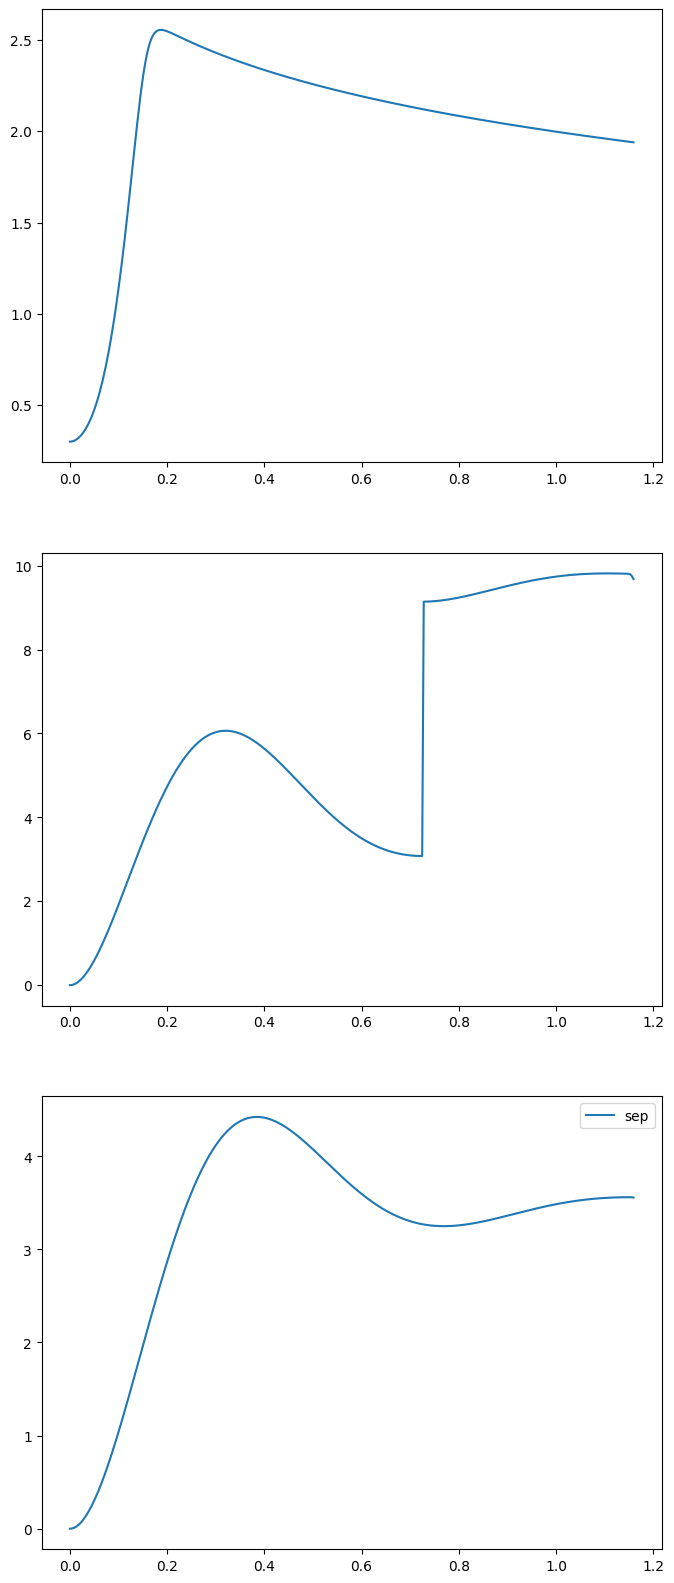

In [8]:
print(1 - 10**-np.max(pf_res))
print(np.max(pf_res))
print(np.min(photon_res[144:288]))

fig, ax = plt.subplots(3, figsize=(8.0, 20.0))

single_res = batch_results[0]
res_g = single_res[:,0] + 1.0j * single_res[:,1]
res_e = single_res[:,2] + 1.0j * single_res[:,3]
sep = jnp.abs(res_g - res_e)

ax[0].plot(env.ts_sim, pf_res)
ax[1].plot(env.ts_sim, photon_res)
ax[2].plot(env.ts_sim, sep, label='sep')
plt.legend()
plt.show()

In [9]:
single_kappa_train = jit(
    PPO_make_train(config),
    static_argnums=(-2, -1)
)

rng, _rng = jax.random.split(rng)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_kappa_result = single_kappa_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
global update: 100
mean batch reward: [16.71412995 15.83160051 16.37668517 16.25607888 16.48327141 16.36082066
 16.23292037 15.49367476]
mean batch pF: [2.43603784 2.40715008 2.42030237 2.41360777 2.39852327 2.4277873
 2.42908332 2.42954939]
mean batch photon: [2.29112196 2.27186537 2.28533101 2.2767787  2.22635889 2.29191494
 2.32770419 2.30447721]
mean batch photon time: [0.41516479 0.41295098 0.40896647 0.41413502 0.40777851 0.42682545
 0.42382855 0.42441074]
mean batch smoothness: [0.0054033  0.00635923 0.00527036 0.00466626 0.00570927 0.00680277
 0.00607468 0.00629527]
max reward obtained: [21.52673387 21.82567596 21.70481176 21.8799399  21.86307093 21.70067585
 21.71950084 21.8029125 ]
pF at max: [2.56768503 2.57325516 2.58388613 2.61893312 2.50100207 2.57289286
 2.5678091  2.46401345]
photon at max: [3.02065444 3.17892623 3.7808795  4.33028555 2.3002491  3.29938197
 3.01062751 2.3758018 ]
photon time of max: [0.41846435 0.41223833 0.431562   0.4360

In [10]:
# Extracting Results

metrics = single_kappa_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]

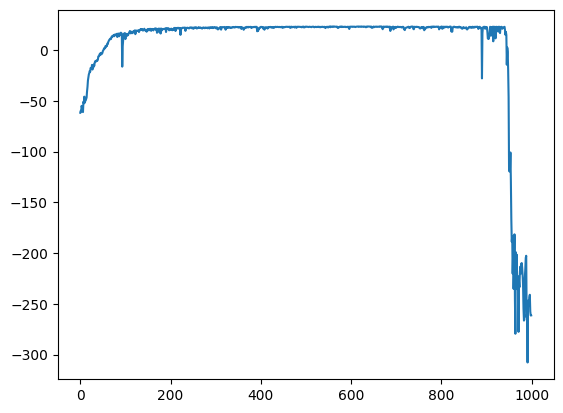

In [11]:
plt.plot(mean_rewards[:, 0])
plt.show()

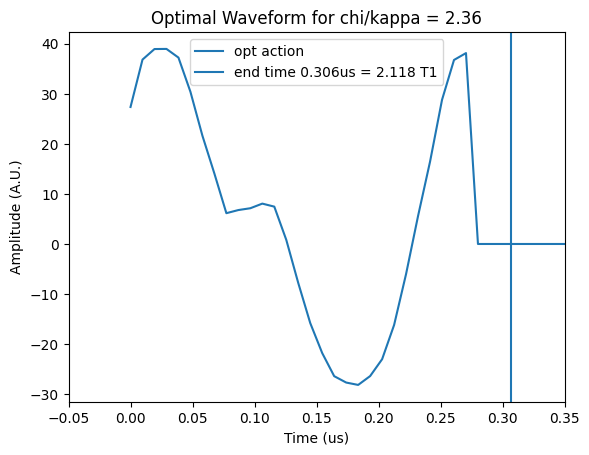

In [16]:
ts_linspace = np.linspace(0., num_t1/kappa, 121)

opt_action = max_actions[-1, 0]
opt_time = max_times[-1, 0]
opt_action *= jnp.heaviside(opt_time - ts_linspace, 1.)
end_time = opt_time + 0.03

plt.plot(ts_linspace, opt_action, label='opt action')
plt.axvline(x=end_time, label=f'end time {int(1e3*end_time)/1e3}us = {int(1e3*end_time * kappa)/1e3} T1')
plt.xlim(-0.05, 0.35)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title(f'Optimal Waveform for chi/kappa = {int(1e2*chi/kappa)/1e2}')
plt.legend()
plt.show()

In [17]:
rl_action = opt_action
# rect_action -= env.a0 * env.mu * (jnp.heaviside(0.35 - env.ts_action, 0.) - jnp.heaviside(0.3 - env.ts_action, 0.))
batch_rl_action = jnp.tile(rl_action, (batchsize, 1))

batch_rl_results = env.batched_results(batch_rl_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    max_pf_times,
    b_smoothness,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batch_rl_results, batch_rl_action)

pf_res = b_pf[0]
photon_res = b_higher_photons[0]

0.9975618192531682
0.0012957001717570419
0.01599525520513052
1.1594202898550725


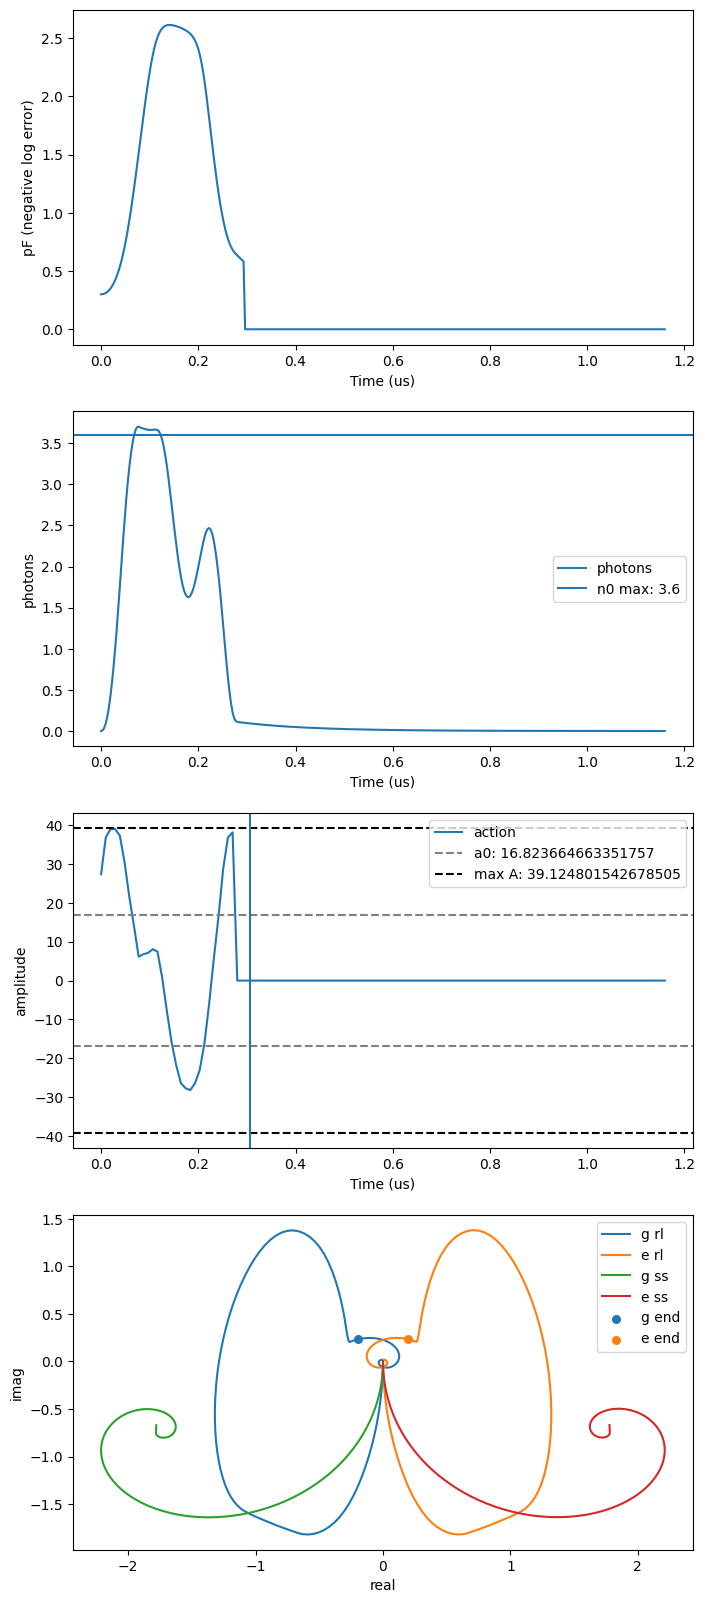

In [19]:
print(1 - 10**-np.max(pf_res))
print(np.min(photon_res[144:288]))

fig, ax = plt.subplots(4, figsize=(8.0, 20.0))

single_rl_res = batch_rl_results[0]
res_rl_g = single_rl_res[:,0] + 1.0j * single_rl_res[:,1]
res_rl_e = single_rl_res[:,2] + 1.0j * single_rl_res[:,3]
sep = jnp.abs(res_g - res_e)

end_ind = jnp.argmin(jnp.abs(end_time - env.ts_sim))

print(jnp.min(np.abs(res_rl_g[45:])))
print(env.ts_sim[jnp.argmin(np.abs(res_rl_g[45:])) + 45])

ax[0].plot(env.ts_sim, pf_res)
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('pF (negative log error)')

ax[1].plot(env.ts_sim, np.abs(res_rl_g) ** 2, label='photons')
ax[1].axhline(y=n0, label=f'n0 max: {n0}')
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('photons')
ax[1].legend()

ax[2].plot(env.ts_action, rl_action, label='action')
ax[2].axhline(y=env.a0, label=f'a0: {env.a0}', color='grey', linestyle='dashed')
ax[2].axhline(y=env.a0 * env.mu, label=f'max A: {env.a0 * env.mu}', color='black', linestyle='dashed')
ax[2].axhline(y=-env.a0, color='grey', linestyle='dashed')
ax[2].axhline(y=-env.a0 * env.mu, color='black', linestyle='dashed')
ax[2].axvline(x=env.ts_sim[end_ind])
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('amplitude')
ax[2].legend()

ax[3].plot(res_rl_g.real, res_rl_g.imag, label='g rl')
ax[3].plot(res_rl_e.real, res_rl_e.imag, label='e rl')
ax[3].plot(res_g.real, res_g.imag, label='g ss')
ax[3].plot(res_e.real, res_e.imag, label='e ss')
ax[3].scatter(res_rl_g[end_ind].real, res_rl_g[end_ind].imag, label='g end', s=30)
ax[3].scatter(res_rl_e[end_ind].real, res_rl_e[end_ind].imag, label='e end', s=30)
ax[3].set_xlabel('real')
ax[3].set_ylabel('imag')
ax[3].legend()
plt.show()